<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [45]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import time
import datetime

In [124]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = r'/Users/nadiiapoliakovska/Documents/MIPT final project (Internet users identification)/capstone_user_identification'

In [16]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [207]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
print(feature_names)

['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10', 'time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5', 'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9', 'session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']


In [301]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ '''
    sites_ids = []
    user_id=[]
    time_diff_all = []
    start_hour = []
    day_of_week = []
    
    pkl_file = open(site_freq_path, 'rb')
    di = pickle.load(pkl_file)
    pkl_file.close()

    p = glob(path_to_csv_files)

    for j in log_progress(np.arange(len(p)), every=1):
        d = pd.read_csv(p[j], header = 0)
        sites = d.iloc[:, 1]
        sessions = [di[list(sites)[i]][0] for i in np.arange(len(sites))]  
        if (len(sites)%session_length>0):
            sites_ids0 = [0]*(session_length-len(sites)%session_length)
            sessions.extend(sites_ids0)
     
        sites_ids.extend(sessions)
        user_id.extend([int(p[j][-8:-4])]*int(np.ceil(len(sites)/10)))
    
        tm = []
        for i in range(len(d)):
            t = time.mktime(datetime.datetime.strptime(d.iloc[i,0], "%Y-%m-%d %H:%M:%S").timetuple())
            tm.append(t)
        if len(tm)%session_length>0:
            t0 = [0]* (session_length - len(tm)%session_length)
            tm.extend(t0)
        
        time_diff = []
        for t in np.arange(int(len(tm)/session_length)):
            for k in np.arange(session_length-1):
                diff = tm[t*10 + k+1] - tm[t*10 +k]
                if diff>0:
                    time_diff.append(diff)
                else:
                    time_diff.append(0)

        time_diff_all.extend(time_diff)
        
        if len(d)%session_length == 0:
            q = len(d)//session_length
        else:
            q = len(d)//session_length+1
        for i in range(q):
            s = datetime.datetime.strptime(d.iloc[i*session_length,0], "%Y-%m-%d %H:%M:%S").timetuple()
            start_hour.append(s[3])
            day_of_week.append(s[6])


    sites_ids = np.array(sites_ids).reshape(( -1, session_length))
    user_id = np.array(user_id).reshape(( -1, 1))

    time_diff_all = np.array(time_diff_all).reshape((-1,time_diff_length))

    session_timespan = []
    for i in time_diff_all:
        session_timespan.append(sum(i))
    session_timespan = np.array(session_timespan).reshape((-1,1))

    unique_sites = []
    for i in sites_ids:
        u = list(set(i))
        if 0 in u:
            u.remove([0])
        unique_sites.append(len(u))
    unique_sites = np.array(unique_sites).reshape((-1,1))

    start_hour = np.array(start_hour).reshape((-1,1))
    day_of_week = np.array(day_of_week).reshape((-1,1))

    e = np.concatenate((sites_ids, time_diff_all, session_timespan, unique_sites, start_hour,\
                                        day_of_week, user_id),axis=1)


    df = pd.DataFrame(data=e, columns=feature_names)
    df = df.astype(int)
    df = df.sort_values('target')
    return df

**Проверим функцию на игрушечном примере.**

In [302]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users/*.csv'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [303]:
train_data_toy 

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
3,10,8,8,4,8,5,1,6,2,9,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
4,10,5,5,5,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
0,10,8,3,3,8,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
1,7,5,8,5,8,5,5,6,11,7,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
2,7,5,8,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [304]:
%%time
train_data_10users = prepare_train_set_with_fe (os.path.join(PATH_TO_DATA, '10users/*.csv'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 2min 10s, sys: 310 ms, total: 2min 10s
Wall time: 2min 10s


In [305]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
11270,3110,2535,4104,2862,3110,2880,2286,3365,2940,3399,0,0,1,0,0,0,0,0,0,1,9,15,4,31
11136,2032,4176,4176,272,4172,2032,272,4172,4176,4907,537554,13,2,2,64,21,0,0,162,537818,5,10,1,31
11137,4907,4907,252,289,289,289,289,2714,1471,1471,2,2172,149672,2,43,2,20,0,1,151914,5,15,0,31
11138,688,1469,1412,2306,4318,206,4172,3851,3056,4318,0,5,8,0,0,0,0,1,0,14,9,9,2,31
11139,4172,348,3758,3851,2707,2906,3050,2707,1736,2805,0,0,0,0,1,0,0,2,1,4,9,9,2,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [306]:
%%time
train_data_150users = prepare_train_set_with_fe (os.path.join(PATH_TO_DATA, '150users/*.csv'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 16min 49s, sys: 2.3 s, total: 16min 51s
Wall time: 16min 51s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [307]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [308]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [309]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [310]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [311]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
11270,3110,2535,4104,2862,3110,2880,2286,3365,2940,3399,0,0,1,0,0,0,0,0,0,1,9,15,4,John
11136,2032,4176,4176,272,4172,2032,272,4172,4176,4907,537554,13,2,2,64,21,0,0,162,537818,5,10,1,John
11137,4907,4907,252,289,289,289,289,2714,1471,1471,2,2172,149672,2,43,2,20,0,1,151914,5,15,0,John
11138,688,1469,1412,2306,4318,206,4172,3851,3056,4318,0,5,8,0,0,0,0,1,0,14,9,9,2,John
11139,4172,348,3758,3851,2707,2906,3050,2707,1736,2805,0,0,0,0,1,0,0,2,1,4,9,9,2,John


**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество сессий')

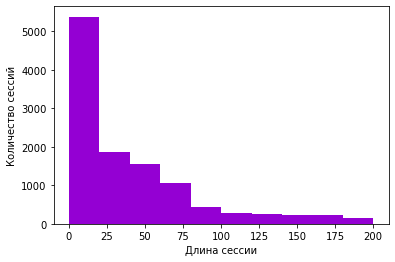

In [317]:
plt.hist(train_data_10users['session_timespan'], range = (0, 200), color = 'darkviolet')
plt.xlabel('Длина сессии')
plt.ylabel('Количество сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество сессий')

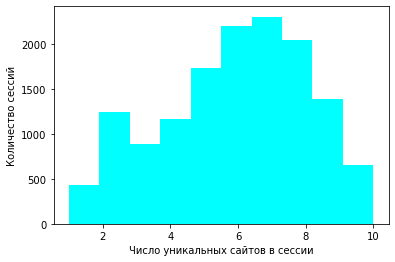

In [319]:
plt.hist(train_data_10users['#unique_sites'], color = 'aqua')
plt.xlabel('Число уникальных сайтов в сессии')
plt.ylabel('Количество сессий')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

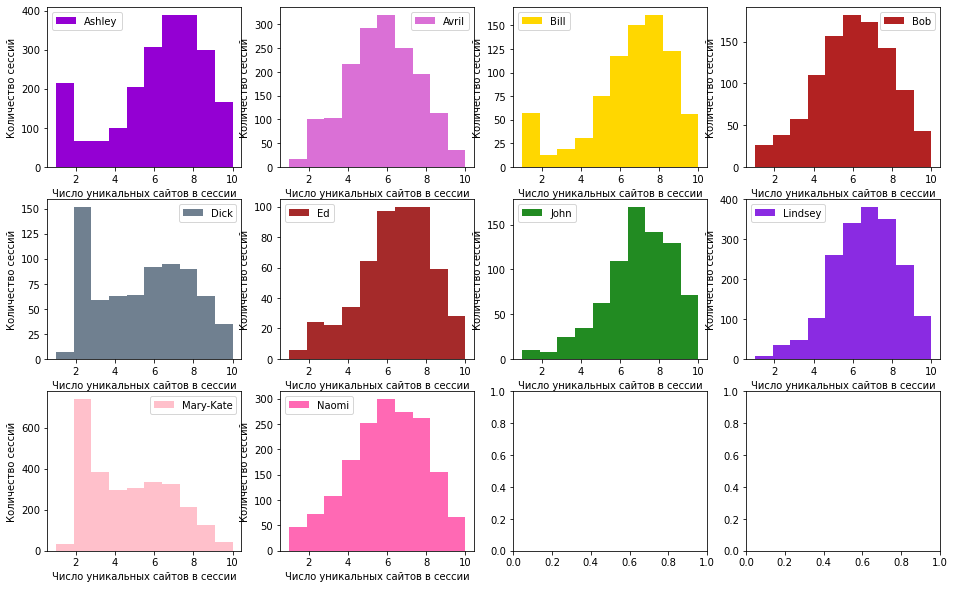

In [366]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), squeeze = False)
axesf = axes.flatten()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_data_10users, 'target')): 
    ''' ВАШ КОД ЗДЕСЬ '''
    axesf[idx].hist(sub_df['#unique_sites'], label = user, color = color_dic[user])
    axesf[idx].legend()
    axesf[idx].set_xlabel('Число уникальных сайтов в сессии')
    axesf[idx].set_ylabel('Количество сессий')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество сессий')

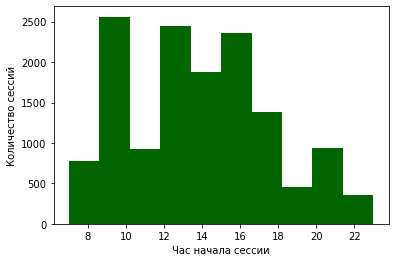

In [368]:
plt.hist(train_data_10users['start_hour'], color = 'darkgreen')
plt.xlabel('Час начала сессии')
plt.ylabel('Количество сессий')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

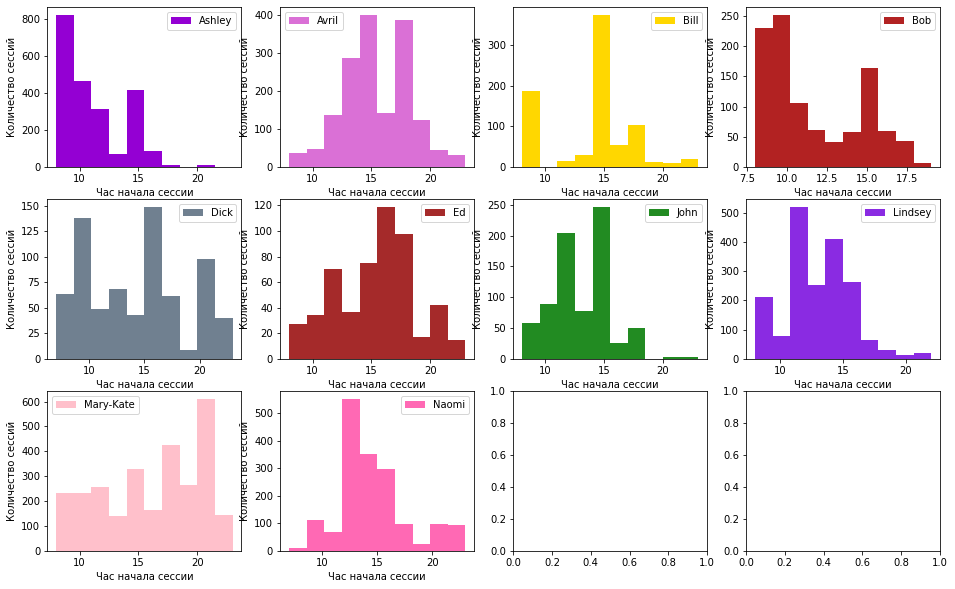

In [369]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), squeeze = False)
axesf = axes.flatten()
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_data_10users, 'target')): 
    ''' ВАШ КОД ЗДЕСЬ '''
    axesf[idx].hist(sub_df['start_hour'], label = user, color = color_dic[user])
    axesf[idx].legend()
    axesf[idx].set_xlabel('Час начала сессии')
    axesf[idx].set_ylabel('Количество сессий')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'Количество сессий')

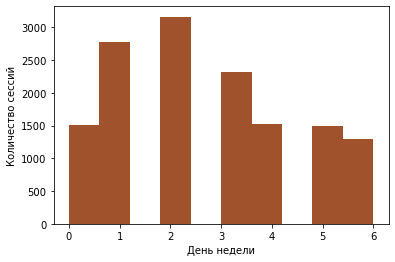

In [370]:
plt.hist(train_data_10users['day_of_week'], color = 'sienna')
plt.xlabel('День недели')
plt.ylabel('Количество сессий')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

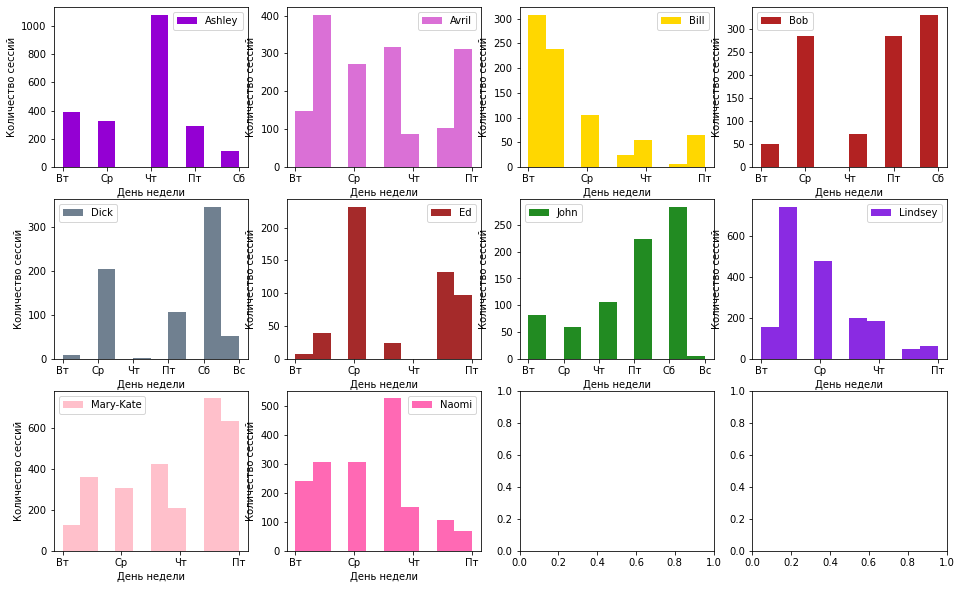

In [511]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), squeeze = False)
axesf = axes.flatten()
l = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] 
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_data_10users, 'target')): 
    ''' ВАШ КОД ЗДЕСЬ '''
    axesf[idx].hist(sub_df['day_of_week'], label = user, color = color_dic[user])
    axesf[idx].legend()
    axesf[idx].set_xlabel('День недели')
    axesf[idx].set_ylabel('Количество сессий')
    axesf[idx].set_xticklabels(l)

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

##### Число уникальных сайтов в сессии:

Ashley: Максимум попадает на 7-8 уникальных сайтов в сессии (немногим меньше 400 сессий). Также есть небольшой пик в районе 1 уникального сайта в сессии (больше 200 сессий).

Avril: Есть 1 максимум в районе 6 уникальных сайтов в сессии (около 300 сессий).

Bill: Глобальный максимум в районе 8 уникальных сайтов (более 150 сессий). Один локальный максимум в районе 1 сайта (более 50 сессий). 

Bob: Глобальный максимум в районе 6 уникальных сайтов (меньше 200 сессий).

Dick: Максимум в районе 2 сайтов (150 сессий). 

Ed:  Глобальный максимум в районе 7-8 уникальных сайтов (около 100 сессий).

John: Глобальный максимум: 7 уникальных сайтов (больше 150 сессий).

Lindsey: Глобальный максимум: 7 уникальных сайтов (меньше 400 сессий).

Mary-Kate: Глобальный максимум: 2 уникальных сайтов (меньше 800 сессий).

Naomi: Глобальный максимум: 6 уникальных сайтов (около 300 сессий).


##### Час начала сессии:

Ashley: Максимум часа начала сессии приходится на время ранее 10 часов (около 800 сессий).

Avril: Есть 2 максимума почти одинаковой высоты (меньше 400 сессий) приходятся на 15 и 18 часов.

Bill: Один максимум приходится на 15 часов (немного меньше 400 сессий). Есть еше один пик ранее 10 часов (до 200 сессий). 

Bob: Максимум - до 10 утра (250 сессий). Еше один небольшой пик в 15 часов (больше 150 сессий).

Dick: Глобальный максимум в 15 часов (150 сессий). Есть еше 2 пика до 10 часов (больше 125 сессий) и в 20 часов (около 100 сессий).

Ed: Максимум - больше 15 часов (около 120 сессий). 

John: Глобальный максимум - 15 (около 250 сессий). Есть еше один пик после 10 часов (около 200 сессий).

Lindsey: Максимум между 10 и 15 часами (более 500 сессий).

Mary-Kate: Максимум в 20 часов (более 600 сессий).

Naomi: Максимум между 10 и 15 часами (более 500 сессий).


##### День недели:

Ashley: Максимум в четверг (более 1000 сессий).

Avril: Максимум приxодится на вторник-среду (около 400 сессий). 

Bill: Максимум во вторник (300 сессий).

Bob: Максимум в субботу (более 300 сессий).

Dick: Максимум в субботу (более 300 сессий).

Ed: Максимум в среду (более 200 сесиий).

John: Максимум в субботу (более 250 сессий).

Lindsey: Максимум во вторник-среду (более 600 сессий).

Mary-Kate: Максимум в пятницу (более 600 сессий).

Naomi:Максимум в четверг (более 500 сессий).

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [385]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as pkl_file_10:
    di_10 = pickle.load(pkl_file_10)
di_10

{'0.docs.google.com': (1, 26),
 '0.drive.google.com': (2, 49),
 '0.gravatar.com': (3, 76),
 '0.talkgadget.google.com': (4, 5),
 '0.tqn.com': (5, 3),
 '0.visuels.poliris.com': (6, 1),
 '00.art.skyrock.net': (7, 1),
 '026-fgm-032.mktoresp.com': (8, 4),
 '077-zjt-858.mktoresp.com': (9, 1),
 '08.mgl.skyrock.net': (10, 1),
 '0pqg0hycqg.s.ad6media.fr': (11, 1),
 '1-50.completr.appspot.com': (12, 9),
 '1.bp.blogspot.com': (13, 21),
 '1.drive.google.com': (14, 5),
 '1.gravatar.com': (15, 59),
 '1.images.gametrailers.com': (16, 1),
 '1.www.s81c.com': (17, 26),
 '10.docs.google.com': (18, 1),
 '13.docs.google.com': (19, 2),
 '160.92.123.193': (20, 91),
 '1822333.r.msn.com': (21, 1),
 '193.164.196.30': (22, 38),
 '193.164.196.40': (23, 43),
 '193.164.196.50': (24, 39),
 '193.164.196.60': (25, 43),
 '193.164.197.30': (26, 37),
 '193.164.197.40': (27, 41),
 '193.164.197.50': (28, 42),
 '193.164.197.60': (29, 40),
 '2.bp.blogspot.com': (30, 29),
 '2.gravatar.com': (31, 6),
 '207-xli-813.mktoresp.com

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [478]:
def top10_popular(site_freq_users):

    site_freq =[]
    values = list(site_freq_users.values())
    for i in list(site_freq_users.values()):
        site_freq.extend([i[1]])

    max_freqs = sorted(site_freq, reverse = True)[0:10]
    
    reversed_max_freq=[]

    for i in reversed(np.unique(max_freqs)):
        reversed_max_freq.extend([i])

    top10_popular_sites=[]
    top10_popular_values = []
    
    for j in reversed_max_freq:
        ind = np.ravel(np.where([i[1]==j for i in values]))
        for i in ind:
            search_value = values[i]
            for key, value in site_freq_users.items():
                if value == search_value:
                    top10_popular_sites.extend([key])
                    top10_popular_values.extend([value[1]])

    return top10_popular_sites, top10_popular_values

In [480]:
top10_freqs = top10_popular(di_10)[0]
top10_sites = top10_popular(di_10)[1]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 's.youtube.com'),
  Text(1, 0, 'www.google.fr'),
  Text(2, 0, 'www.google.com'),
  Text(3, 0, 'mail.google.com'),
  Text(4, 0, 'www.facebook.com'),
  Text(5, 0, 'apis.google.com'),
  Text(6, 0, 'r3---sn-gxo5uxg-jqbe.googlevideo.com'),
  Text(7, 0, 'r1---sn-gxo5uxg-jqbe.googlevideo.com'),
  Text(8, 0, 'plus.google.com'),
  Text(9, 0, 'accounts.google.com')])

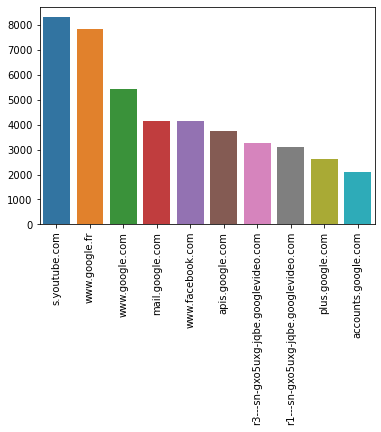

In [481]:
sns.barplot(top10_freqs, top10_sites)
plt.xticks(rotation='vertical')

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [482]:
''' ВАШ КОД ЗДЕСЬ '''
np.median(train_data_10users['session_timespan'])

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [483]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(train_data_10users['day_of_week'])

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [484]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(train_data_150users['start_hour'])

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [485]:
''' ВАШ КОД ЗДЕСЬ ''' 
np.median(train_data_150users['#unique_sites'])

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [488]:
def top30_popular(site_freq_users):

    site_freq =[]
    values = list(site_freq_users.values())
    for i in list(site_freq_users.values()):
        site_freq.extend([i[1]])

    max_freqs = sorted(site_freq, reverse = True)[0:30]
    
    reversed_max_freq=[]

    for i in reversed(np.unique(max_freqs)):
        reversed_max_freq.extend([i])

    top30_popular=[]

    for j in reversed_max_freq:
        ind = np.ravel(np.where([i[1]==j for i in values]))
        for i in ind:
            search_value = values[i]
            for key, value in site_freq_users.items():
                if value == search_value:
                    top30_popular.extend([key])
    return top30_popular

In [503]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'year','month', 'day', 'in_top30',  'target']
path_to_csv_files = os.path.join(PATH_TO_DATA, '3users/*.csv')
site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl')
import time

In [507]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 
    sites_ids = []
    user_id=[]
    time_diff_all = []
    start_hour = []
    day_of_week = []
    year=[]
    month=[]
    day=[]
    in_top30 = []

    pkl_file = open(site_freq_path, 'rb')
    di = pickle.load(pkl_file)
    pkl_file.close()

    p = glob(path_to_csv_files)

    top30 = top30_popular(di)
    top30_pop_ind = [di[top30_popular(di)[i]][0] for i in range(len(top30_popular(di)))]

    for j in log_progress(np.arange(len(p)), every=1):
        #for j in np.arange(len(p)):
        d = pd.read_csv(p[j], header = 0)
        sites = d.iloc[:, 1]
        sessions = [di[list(sites)[i]][0] for i in np.arange(len(sites))]  
        if (len(sites)%session_length>0):
            sites_ids0 = [0]*(session_length-len(sites)%session_length)
            sessions.extend(sites_ids0)


        sites_ids.extend(sessions)
        user_id.extend([int(p[j][-8:-4])]*int(np.ceil(len(sites)/session_length)))

        tm = []
        for i in range(len(d)):
            t = time.mktime(datetime.datetime.strptime(d.iloc[i,0], "%Y-%m-%d %H:%M:%S").timetuple())
            tm.append(t)
        if len(tm)%session_length>0:
            t0 = [0]* (session_length - len(tm)%session_length)
            tm.extend(t0)

        time_diff = []
        for t in np.arange(int(len(tm)/session_length)):
            for k in np.arange(session_length-1):
                diff = tm[t*10 + k+1] - tm[t*10 +k]
                if diff>0:
                    time_diff.append(diff)
                else:
                    time_diff.append(0)

        time_diff_all.extend(time_diff)

        if len(d)%session_length == 0:
            q = len(d)//session_length
        else:
            q = len(d)//session_length+1
        for i in range(q):
            s = datetime.datetime.strptime(d.iloc[i*session_length,0], "%Y-%m-%d %H:%M:%S").timetuple()
            start_hour.append(s[3])
            day_of_week.append(s[6])
            year.append(s[0])
            month.append(s[1])
            day.append(s[2])

    sites_ids = np.array(sites_ids).reshape(( -1, session_length))

    for i in sites_ids:
        indicator=0
        for n in i:
            if n in top30_pop_ind:
                indicator = indicator+1
        in_top30.append(indicator)

    in_top30 = np.array(in_top30).reshape(( -1, 1))


    user_id = np.array(user_id).reshape(( -1, 1))

    time_diff_all = np.array(time_diff_all).reshape((-1,time_diff_length))

    session_timespan = []
    for i in time_diff_all:
        session_timespan.append(sum(i))
    session_timespan = np.array(session_timespan).reshape((-1,1))

    unique_sites = []
    for i in sites_ids:
        u = list(set(i))
        if 0 in u:
            u.remove([0])
        unique_sites.append(len(u))
    unique_sites = np.array(unique_sites).reshape((-1,1))

    start_hour = np.array(start_hour).reshape((-1,1))
    day_of_week = np.array(day_of_week).reshape((-1,1))
    year = np.array(year).reshape((-1,1))
    month = np.array(month).reshape((-1,1))
    day = np.array(day).reshape((-1,1))

    e = np.concatenate((sites_ids, time_diff_all, session_timespan, unique_sites, start_hour,\
                                            day_of_week, year, month, day, in_top30, user_id),axis=1)


    df = pd.DataFrame(data=e, columns=features)
    df = df.astype(int)
    df = df.sort_values('target')
    return df

In [542]:
new_features_10users = feature_engineering(path_to_csv_files = os.path.join(PATH_TO_DATA, '10users/*.csv'),
                                           site_freq_path = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                           features = feature_names, session_length=10) 

In [509]:
new_features_150users = feature_engineering(path_to_csv_files = os.path.join(PATH_TO_DATA, '150users/*.csv'),
                                           site_freq_path = os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                           features = feature_names, session_length=10) 

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

#### 14.1. Гистограммы распределения года, в котором проходили сессии, для каждого пользователя.


In [543]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict) # даем каждомы пользователю имя 

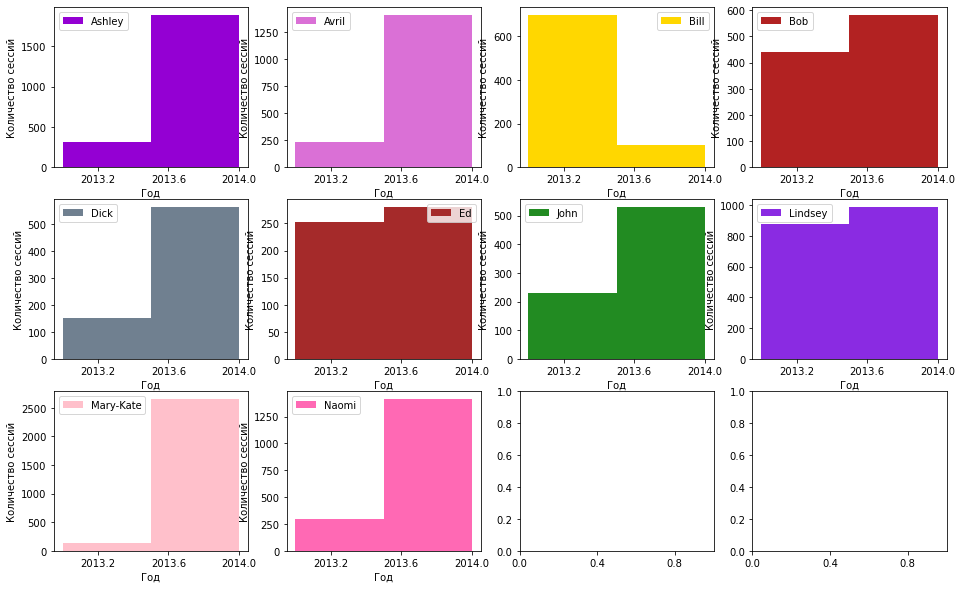

In [590]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), squeeze = False)
axesf = axes.flatten() 

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(new_features_10users, 'target')): 
    axesf[idx].hist(sub_df['year'], bins = 2, label = user, color = color_dic[user])
    axesf[idx].legend()
    axesf[idx].set_xlabel('Год')
    axesf[idx].set_ylabel('Количество сессий')
    #axesf[idx].set_xticklabels(['2013', '2014'])
for axi in axes.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(3))

#### Анализ гистиграмм распределения года, в котором проходили сессии.

Ashley: Значительно больше сессий было проведено в 2014 году (более 1500).

Avril:  Значительно больше сессий было проведено в 2014 году (более 1250).

Bill:  Значительно больше сессий было проведено в 2013 году (более 600).

Bob: Разница между 2013 и 2014 годами не большая. Но больше всего сессий все же было в 2014 (почти 600).

Dick:  Значительно больше сессий было проведено в 2014 году (более 500).

Ed: Разница между 2013 и 2014 годами не большая. Но больше всего сессий все же было в 2014 (более 250).

John: Значительно больше сессий было проведено в 2014 году (более 500).

Lindsey: Разница между 2013 и 2014 годами не большая. Но больше всего сессий все же было в 2014 (почти 1000).

Mary_Kate: Значительно больше сессий было проведено в 2014 году (более 2500).

Naomi: Значительно больше сессий было проведено в 2014 году (более 1250).

#### 14.2. Гистограммы распределения дат, когда проходили сессии, для каждого пользователя.

In [566]:
# добавим столбик с датами к таблице new_features_10users
new_features_10users['year_month_day'] = new_features_10users['year'].astype(str)+ '-' + new_features_10users['month'].astype(str) + '-' + new_features_10users['day'].astype(str)
new_features_10users['year_month_day'] = new_features_10users['year_month_day'].astype("datetime64")

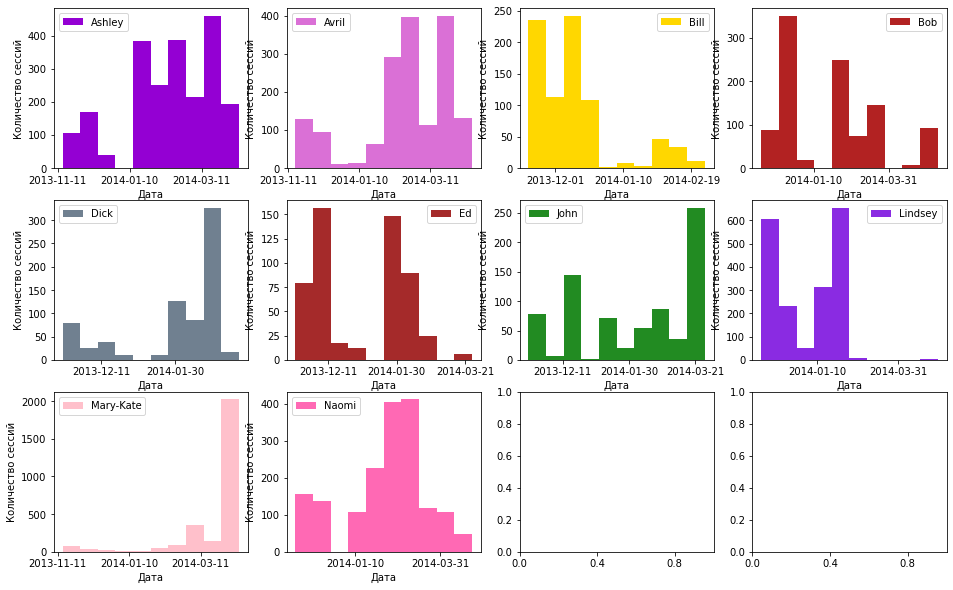

In [586]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), squeeze = False)
axesf = axes.flatten() 

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(new_features_10users, 'target')): 
    axesf[idx].hist(sub_df['year_month_day'], label = user, color = color_dic[user])
    axesf[idx].legend()
    axesf[idx].set_xlabel('Дата')
    axesf[idx].set_ylabel('Количество сессий')
for axi in axes.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(3))

#### Анализ гистограмм распределения дат, когда были проведены сессии:

Ashley: Большинство сессий было в 2014 году. Максимум после 2014/03/11 (больше 400 сессий).

Avril: Большинство сессий было в 2014 году. Один пик - 2014/02, второй - 2014/04 (оба пика больше 400 сессий).

Bill: Большинство сессий было в 2013 году. Один пик - 2013/11, второй - около 2013/12 (оба пика почти 250 сессий).

Bob: Максимум количества сессий 2013/12 (больше 300).

Dick: Максимум количества сессий в 2014 году (больше 300).

Ed: Почти одинаковые пики в 2013 и 2014 году, но в 2013 все же выше (больше 150 сессий).

John: Максимум количества сессий 2014/03/21 (больше 250).

Lindsey: Почти одинаковые пики в 2013 и 2014 году, но в 2014 все же выше (больше 600 сессий).

Mary-Kate: Максимум количества сессий в 2014 году (около 2000 сессий).

Naomi: Максимум количества сессий в 2014 году (около 400 сессий).

#### 14.3. Гистограммы посещений топ 30 популярных сайтов для каждого пользователя.

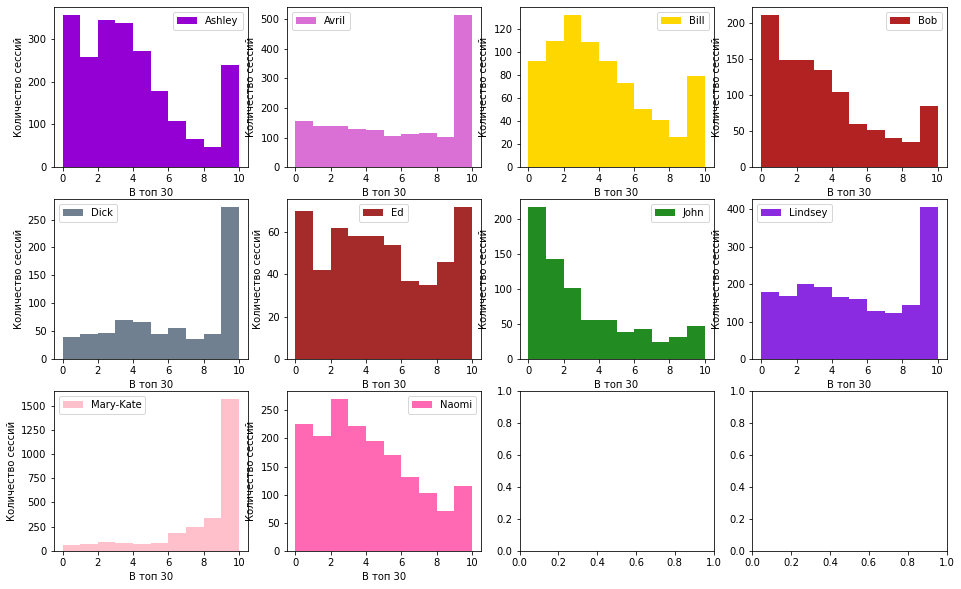

In [548]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), squeeze = False)
axesf = axes.flatten() 

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(new_features_10users, 'target')): 
    axesf[idx].hist(sub_df['in_top30'], label = user, color = color_dic[user])
    axesf[idx].legend()
    axesf[idx].set_xlabel('В топ 30')
    axesf[idx].set_ylabel('Количество сессий')

#### Анализ гистограмм посещения топ 30 популярных сайтов.

Ashley: Максимум припадает на 1 популярный сайт в сессии (более 300 сессий).

Avril: Максимум припадает на 10 популярных сайтов в сессии (около 500 сессий).

Bill: Максимум припадает на 3 популярных сайта в сессии (более 120 сессий).

Bob: Максимум припадает на 1 популярный сайт в сессии (более 200 сессий).

Dick: Максимум припадает на 10 популярных сайтов в сессии (более 250 сессий).

Ed: Значения не очень разнятся. Максимум припадает на 10 сайтов (более 60 сессий).

John: Максимум припадает на 1 популярный сайт в сессии (более 200 сессий).

Lindsey: Максимум припадает на 10 популярных сайтов в сессии (около 400 сессий).

Mary-Kate: Максимум припадает на 10 популярных сайтов в сессии (более 1500 сессий).

Naomi: Максимум припадает на 3 популярных сайта в сессии (более 250 сессий).

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [573]:
new_features_150users['year_month_day'] = new_features_150users['year'].astype(str)+ '-' + new_features_150users['month'].astype(str) + '-' + new_features_150users['day'].astype(str)
new_features_150users['year_month_day'] = new_features_150users['year_month_day'].astype("datetime64")

In [574]:
selected_features_10users = new_features_10users[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'in_top30', 'year_month_day']] 
selected_features_150users = new_features_150users[['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'in_top30', 'year_month_day']] 

In [575]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 